In [1]:
import numpy as np
import pandas as pd
import pickle
import torch
import sys
import matplotlib.pyplot as plt
from matplotlib import cm,colors
from warnings import filterwarnings
from tqdm import tqdm
import seaborn as sns
import scanpy as sc
import glob
import pytorch_lightning as pl

In [2]:
pl.seed_everything(12)

Seed set to 12


12

### Gather performance and plotting

In [3]:
config = {
    "dataset": "norman_k562",
    "use_hvg": True,
    "dataset_name": "norman_k562_hvg",
    "include_moe": False,
    "test_set_id": "random_split_5_2",
    "null_label": "zeros",
    "epochs": 100,
    "tolerance_epoch": 20,
    "val_ratio": 0.1,
    "ood_ratio": 0.15,
    "latdim_ctrl": 50,
    "latdim_ptb": 50,
    "geneset_num": 50,
    "mxAlpha": 2.0,
    "prior": "DepMap_GeneEffect",
    "model_type": "mvae_attention_vae_14_3",
    "random_seed": 12
}

In [4]:
import os
savedir = (f"./{config['dataset_name']}/{config['test_set_id']}/"
           f"null_label_{config['null_label']}/prior_{config['prior']}/tolerance_epoch_{config['tolerance_epoch']}/")

if not os.path.exists(savedir):
    os.makedirs(savedir)

In [5]:
import json
with open(f"{savedir}/umap_config.json", "w") as f:
    json.dump(config, f, indent=4)

In [6]:
adata_file_path = '/home/che/perturb-project/git/gene_ptb_prediction/scdata_file_path.csv'
adata_file = pd.read_csv(adata_file_path)
adata_path = adata_file[(adata_file['dataset'] == config['dataset']) & (adata_file['use_hvg'] == config['use_hvg'])]['file_path'].values[0]
adata = sc.read(adata_path)
print('Read adata from', adata_path)

/home/che/anaconda3/envs/geneformer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


Read adata from /home/che/perturb-project/predict_model/dataset/norman_2019/Norman2019_normalized_hvg.h5ad


/home/che/anaconda3/envs/geneformer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


### Step 1. Read in data

In [7]:
gears_path = f"/home/che/GEARS/{config['dataset_name']}/{config['test_set_id']}/random_seed_{config['random_seed']}/gears_pred_dict.pkl"
gears_pred_dict = pickle.load(open(gears_path, 'rb'))

In [8]:
linear_path = f"/home/che/perturb-project/git/gene_ptb_prediction/baseline_model/linear_model/{config['dataset_name']}/{config['test_set_id']}_seed_12_linear_salt_pred.pkl"
linear_pred_dict = pickle.load(open(linear_path, 'rb'))

In [9]:
vae_attention_path = f"/home/che/perturb-project/predict_model/result/rna/{config['dataset_name']}"
vae_attention_path_parent_temp = (f"{vae_attention_path}/latdim_ctrl_{config['latdim_ctrl']}_latdim_ptb_{config['latdim_ptb']}_geneset_num_{config['geneset_num']}/{config['test_set_id']}/"
                            f"recon_loss_mmd/null_label_{config['null_label']}/epochs_{config['epochs']}/"
                            f"tolerance_epochs_{config['tolerance_epoch']}/mxAlpha_{config['mxAlpha']}/"
                            f"val_{config['val_ratio']}_ood_{config['ood_ratio']}/random_seed_{config['random_seed']}")
pattern = f"{vae_attention_path_parent_temp}/{config['prior']}_{config['model_type']}_run*"
vae_attention_path_temp = glob.glob(pattern)
assert len(vae_attention_path_temp) == 1, f'Error: {pattern}'
vae_attention_path_temp = vae_attention_path_temp[0]
vae_pred_dict = pickle.load(open(f'{vae_attention_path_temp}/best_model_pred_test.pkl', 'rb'))
summary_eval = pd.read_csv(f'{vae_attention_path_temp}/best_model_evaluations.csv')

In [10]:
# read in change from control
change_df = pd.read_csv('/home/che/perturb-project/predict_model/dataset/norman_2019/norman_k562_hvg_mmd_distance_1500_to_non-targeting.csv')
change_df = change_df[['ptb_gene', 'mean_mmd_distance', 'data_size']]

# merge with sumary_eval
summary_eval = summary_eval.merge(change_df, left_on='pert', right_on='ptb_gene', how='left')

In [11]:
summary_eval.sort_values('mean_mmd_distance', ascending=False, inplace=True)
# summary_eval[summary_eval['mmd'] < 0.5].head(10)
# top_n = 30
# summary_eval = summary_eval.head(top_n)
summary_eval.head(5)

,pert,mmd,rmse,mse,r2,pearsonr,rmse_change,pearsonr_change,fraction,ptb_gene,mean_mmd_distance,data_size
17,JUN+CEBPA,0.120592,0.043331,0.001878,0.000000,NaN,0.043331,0.098215,0.50,JUN+CEBPA,1.164034,32
20,CEBPE+SPI1,0.768742,0.376533,0.141777,0.902720,0.957824,0.376533,0.959955,0.98,CEBPE+SPI1,0.965705,160
70,CEBPA,0.495882,0.223906,0.050134,0.940372,0.976192,0.223906,0.977215,1.00,CEBPA,0.857535,448
48,CEBPE+CEBPA,0.522421,0.291557,0.085005,0.940388,0.971868,0.291557,0.971526,0.92,CEBPE+CEBPA,0.828148,160
72,CEBPB+CEBPA,0.117346,0.035983,0.001295,0.000000,0.230939,0.035983,0.653227,0.56,CEBPB+CEBPA,0.793512,64


### Step 2. Label the unseen type and gi type of gene-pair perturbations

In [12]:
# Extract single genes and determine unseen type
df = summary_eval.copy()
df['unseen_type'] = np.nan  # Initialize with NaN

# Create a set of all single-gene pert entries for quick lookup
single_genes = set(df['pert'][~df['pert'].str.contains(r'\+')])

# Function to determine unseen type
def determine_unseen_type(row):
    if '+' in row['pert']:
        genes = row['pert'].split('+')
        single_count = sum(gene in single_genes for gene in genes)
        return f"{single_count}/2 unseen"  # 2 - single_count gives the unseen count
    else:
        return '0/2 unseen'  # Single genes are considered 0/2 unseen

# Apply function to each row
df['unseen_type'] = df.apply(determine_unseen_type, axis=1)

# Display the result
df[['pert', 'unseen_type']].head(5)

,pert,unseen_type
17,JUN+CEBPA,2/2 unseen
20,CEBPE+SPI1,0/2 unseen
70,CEBPA,0/2 unseen
48,CEBPE+CEBPA,1/2 unseen
72,CEBPB+CEBPA,1/2 unseen


In [13]:
# now read in gi_type
gi_path = '/home/che/perturb-project/data/norman_k562/norman_table/GI_gene_pair.csv'
gi_df = pd.read_csv(gi_path)
# rename synergy similar and synergy dissimilar to synergy
gi_df.loc[gi_df['Type'] == 'Strong Synergy (Dissimilar Phenotypes)', 'Type'] = 'synergy'
gi_df.loc[gi_df['Type'] == 'Strong Synergy (Similar Phenotypes)', 'Type'] = 'synergy'

# turn all into lower case
gi_df['Type'] = gi_df['Type'].str.lower()
print(gi_df['Type'].unique())

# create combinations of gene pairs
adata = sc.read_h5ad('/home/che/perturb-project/predict_model/dataset/norman_2019/Norman2019_normalized_hvg.h5ad')
all_ptb_targets = adata.obs['gene'].unique().tolist()
all_ptb_targets.remove('non-targeting')

for i, row in gi_df.iterrows():
    gene1 = row['Gene1']
    gene2 = row['Gene2']
    interaction_type = row['Type']
    pair1 = f'{gene1}+{gene2}'
    pair2 = f'{gene2}+{gene1}'
    if pair1 in all_ptb_targets:
        gi_df.loc[i, 'combination'] = pair1
    elif pair2 in all_ptb_targets:
        gi_df.loc[i, 'combination'] = pair2
    else:
        print(f'Pair {pair1} not found in gi_scores')

['neomorphic' 'additive' 'epistasis' 'redundant' 'potentiation' 'synergy'
 'suppressors']
Pair RHOXF2B+SET not found in gi_scores


/home/che/anaconda3/envs/geneformer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [14]:
# merge gi_df with df
df = df.merge(gi_df[['combination', 'Type']], left_on='pert', right_on='combination', how='left')
df.head(5)

,pert,mmd,rmse,mse,r2,pearsonr,rmse_change,pearsonr_change,fraction,ptb_gene,mean_mmd_distance,data_size,unseen_type,combination,Type
0,JUN+CEBPA,0.120592,0.043331,0.001878,0.000000,NaN,0.043331,0.098215,0.50,JUN+CEBPA,1.164034,32,2/2 unseen,NaN,NaN
1,CEBPE+SPI1,0.768742,0.376533,0.141777,0.902720,0.957824,0.376533,0.959955,0.98,CEBPE+SPI1,0.965705,160,0/2 unseen,CEBPE+SPI1,redundant
2,CEBPA,0.495882,0.223906,0.050134,0.940372,0.976192,0.223906,0.977215,1.00,CEBPA,0.857535,448,0/2 unseen,NaN,NaN
3,CEBPE+CEBPA,0.522421,0.291557,0.085005,0.940388,0.971868,0.291557,0.971526,0.92,CEBPE+CEBPA,0.828148,160,1/2 unseen,CEBPE+CEBPA,redundant
4,CEBPB+CEBPA,0.117346,0.035983,0.001295,0.000000,0.230939,0.035983,0.653227,0.56,CEBPB+CEBPA,0.793512,64,1/2 unseen,CEBPB+CEBPA,redundant


In [15]:
df.to_csv(f'{savedir}/summary_eval.csv', index=False)

### Step 3. Subset to check UMAP

In [16]:
df_subset = df[df['pert'].isin(gears_pred_dict.keys())]
df_subset = df_subset[df_subset['pert'].isin(vae_pred_dict.keys())]
df_subset = df_subset[df_subset['pert'].isin(linear_pred_dict.keys())]
df_subset.sort_values('mean_mmd_distance', ascending=False, inplace=True)
df_subset.head(5)

,pert,mmd,rmse,mse,r2,pearsonr,rmse_change,pearsonr_change,fraction,ptb_gene,mean_mmd_distance,data_size,unseen_type,combination,Type
0,JUN+CEBPA,0.120592,0.043331,0.001878,0.000000,NaN,0.043331,0.098215,0.50,JUN+CEBPA,1.164034,32,2/2 unseen,NaN,NaN
1,CEBPE+SPI1,0.768742,0.376533,0.141777,0.902720,0.957824,0.376533,0.959955,0.98,CEBPE+SPI1,0.965705,160,0/2 unseen,CEBPE+SPI1,redundant
3,CEBPE+CEBPA,0.522421,0.291557,0.085005,0.940388,0.971868,0.291557,0.971526,0.92,CEBPE+CEBPA,0.828148,160,1/2 unseen,CEBPE+CEBPA,redundant
4,CEBPB+CEBPA,0.117346,0.035983,0.001295,0.000000,0.230939,0.035983,0.653227,0.56,CEBPB+CEBPA,0.793512,64,1/2 unseen,CEBPB+CEBPA,redundant
5,FOSB+CEBPE,0.288398,0.100552,0.010111,0.986681,0.994014,0.100552,0.987992,0.92,FOSB+CEBPE,0.685361,128,0/2 unseen,FOSB+CEBPE,redundant


In [17]:
df_subset

,pert,mmd,rmse,mse,r2,pearsonr,rmse_change,pearsonr_change,fraction,ptb_gene,mean_mmd_distance,data_size,unseen_type,combination,Type
0,JUN+CEBPA,0.120592,0.043331,0.001878,0.000000,NaN,0.043331,0.098215,0.50,JUN+CEBPA,1.164034,32,2/2 unseen,NaN,NaN
1,CEBPE+SPI1,0.768742,0.376533,0.141777,0.902720,0.957824,0.376533,0.959955,0.98,CEBPE+SPI1,0.965705,160,0/2 unseen,CEBPE+SPI1,redundant
3,CEBPE+CEBPA,0.522421,0.291557,0.085005,0.940388,0.971868,0.291557,0.971526,0.92,CEBPE+CEBPA,0.828148,160,1/2 unseen,CEBPE+CEBPA,redundant
4,CEBPB+CEBPA,0.117346,0.035983,0.001295,0.000000,0.230939,0.035983,0.653227,0.56,CEBPB+CEBPA,0.793512,64,1/2 unseen,CEBPB+CEBPA,redundant
5,FOSB+CEBPE,0.288398,0.100552,0.010111,0.986681,0.994014,0.100552,0.987992,0.92,FOSB+CEBPE,0.685361,128,0/2 unseen,FOSB+CEBPE,redundant
6,FEV+ISL2,0.376123,0.168881,0.028521,0.987299,0.995100,0.168881,0.962754,0.94,FEV+ISL2,0.681568,256,1/2 unseen,FEV+ISL2,potentiation
7,JUN+CEBPB,0.084145,0.039548,0.001564,0.000000,NaN,0.039548,0.494717,0.54,JUN+CEBPB,0.679827,32,1/2 unseen,NaN,NaN
8,ZBTB10+SNAI1,0.105581,0.045904,0.002107,0.960868,0.994787,0.045904,0.988872,0.46,ZBTB10+SNAI1,0.669891,96,1/2 unseen,ZBTB10+SNAI1,additive
10,ZC3HAV1+CEBPA,0.143901,0.043749,0.001914,0.995996,0.998281,0.043749,0.990291,0.68,ZC3HAV1+CEBPA,0.637592,64,2/2 unseen,ZC3HAV1+CEBPA,epistasis
11,PRDM1+CBFA2T3,0.247341,0.084837,0.007197,0.988709,0.996704,0.084837,0.949150,0.46,PRDM1+CBFA2T3,0.627183,96,0/2 unseen,NaN,NaN


In [18]:
# test_check_list = top_df['pert'].unique().tolist()
test_check_list = df_subset.head(12)['pert'].tolist()
print('test_check_list:', test_check_list)
print('length of test_check_list:', len(test_check_list))

test_check_list: ['JUN+CEBPA', 'CEBPE+SPI1', 'CEBPE+CEBPA', 'CEBPB+CEBPA', 'FOSB+CEBPE', 'FEV+ISL2', 'JUN+CEBPB', 'ZBTB10+SNAI1', 'ZC3HAV1+CEBPA', 'PRDM1+CBFA2T3', 'ETS2+IKZF3', 'IRF1+SET']
length of test_check_list: 12


In [19]:
true_y_gene_expressions = {}
vae_expressions= {}
gears_expressions = {}
linear_expressions = {}

for pert_name in tqdm(test_check_list):
    # print('Pert name', pert_name)

    if pert_name not in gears_pred_dict or pert_name not in vae_pred_dict:
        print(f'Error: {pert_name} not in gears_pred_dict or vae_pred_dict')
        continue
    true_y = adata[adata.obs['gene'] == pert_name].X
    pred_y_vae = vae_pred_dict[pert_name]
    pred_gears = gears_pred_dict[pert_name+'+ctrl' if '+' not in pert_name else pert_name]
    pred_linear = linear_pred_dict[pert_name]

    # get min of sample size
    min_sample_size = min(
                          true_y.shape[0],
                          pred_y_vae.shape[0],
                          pred_gears.shape[0],
                          pred_linear.shape[0])
    # print('Min sample size', min_sample_size)

    # random sample from all predictions to make same size
    true_y = true_y[np.random.choice(true_y.shape[0], min_sample_size, replace=False),:]
    pred_y_vae = pred_y_vae[np.random.choice(pred_y_vae.shape[0], min_sample_size, replace=False),:]
    pred_gears = pred_gears[np.random.choice(pred_gears.shape[0], min_sample_size, replace=False),:]
    pred_linear = pred_linear[np.random.choice(pred_linear.shape[0], min_sample_size, replace=False),:]
    assert true_y.shape[0] == pred_y_vae.shape[0] == pred_gears.shape[0], 'Error: sample size not match'

    true_y_gene_expressions[pert_name] = true_y
    vae_expressions[pert_name] = pred_y_vae
    gears_expressions[pert_name] = pred_gears
    linear_expressions[pert_name] = pred_linear
    

100%|██████████| 12/12 [00:00<00:00, 58.88it/s]


### 3. UMAP

In [20]:
adata_ctrl = adata[adata.obs['gene'] == 'non-targeting'].copy()
ctrl_X = adata_ctrl.X

all_data = np.vstack([ctrl_X, 
                      np.vstack(list(true_y_gene_expressions.values())),
                      np.vstack(list(vae_expressions.values())),
                      np.vstack(list(gears_expressions.values())),
                      np.vstack(list(linear_expressions.values()))
                    ])
                      

adata_new = sc.AnnData(all_data)
adata_new

AnnData object with n_obs × n_vars = 19535 × 5044

In [21]:
# Assign labels for each model in adata_new.obs
adata_new.obs['model'] = (
    ['Control cells'] * ctrl_X.shape[0] +
    ['Perturbed cells'] * np.vstack(list(true_y_gene_expressions.values())).shape[0] +
    ['Our model'] * np.vstack(list(vae_expressions.values())).shape[0] +
    ['Gears'] * np.vstack(list(gears_expressions.values())).shape[0] +
    ['Linear+SALT'] * np.vstack(list(linear_expressions.values())).shape[0]
)
adata_new

AnnData object with n_obs × n_vars = 19535 × 5044
    obs: 'model'

In [22]:
# Create the 'gene' column by repeating each key in `true_y_gene_expressions` by the count of its entries
gene_labels = ['non-targeting'] * ctrl_X.shape[0]
for gene, expression_data in true_y_gene_expressions.items():
    gene_labels.extend([gene] * expression_data.shape[0])

for gene, expression_data in vae_expressions.items():
    gene_labels.extend([gene] * expression_data.shape[0])

for gene, expression_data in gears_expressions.items():
    gene_labels.extend([gene] * expression_data.shape[0])

for gene, expression_data in linear_expressions.items():
    gene_labels.extend([gene] * expression_data.shape[0])

# Assign gene labels to adata_new.obs['gene']
adata_new.obs['gene'] = gene_labels
adata_new

AnnData object with n_obs × n_vars = 19535 × 5044
    obs: 'model', 'gene'

In [23]:
# calculate PCA and UMAP
random_seed = config['random_seed']
np.random.seed(random_seed)
sc.settings.seed = random_seed  # Set seed for scanpy
sc.tl.pca(adata_new, svd_solver='arpack')
sc.pp.neighbors(adata_new, n_neighbors=30, n_pcs=50)
sc.tl.umap(adata_new, min_dist=0.3)

/home/che/anaconda3/envs/geneformer/lib/python3.10/site-packages/pynndescent/pynndescent_.py:346: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a future release. See details at https://numba.readthedocs.io/en/latest/reference/deprecation.html#deprecation-of-old-style-numba-captured-errors
Exception origin:
  File "/home/che/anaconda3/envs/geneformer/lib/python3.10/site-packages/numba/core/types/functions.py", line 486, in __getnewargs__
    raise ReferenceError("underlying object has vanished")

  init_rp_tree(data, dist, current_graph, leaf_array)
/home/che/anaconda3/envs/geneformer/lib/python3.10/site-packages/pynndescent/pynndescent_.py:348: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a future release. See details at https://numba.readth

In [24]:
# save the adata_new
adata_new.write(f'{savedir}/adata_umap.h5ad')

/tmp/ipykernel_3860529/467629156.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model = adata_new.obs['model'][idx]


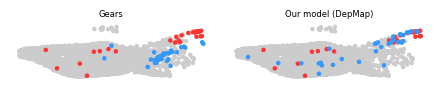

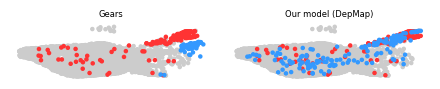

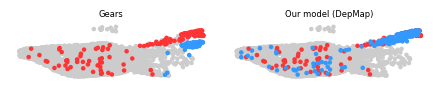

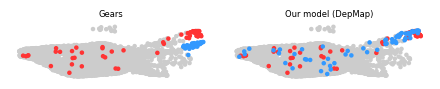

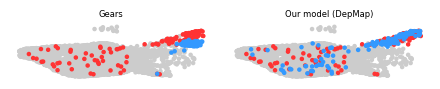

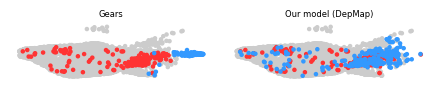

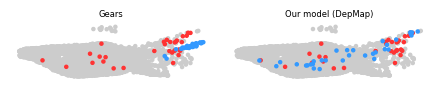

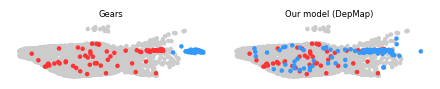

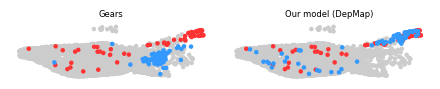

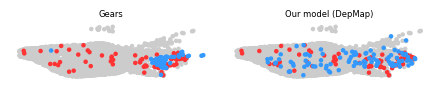

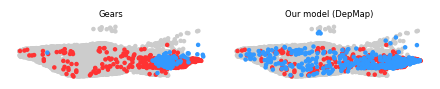

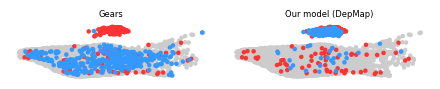

In [25]:
import matplotlib.pyplot as plt
import scanpy as sc

# Get unique perturbations and remove control label
perturbations = adata_new.obs['gene'].unique().tolist()
perturbations.remove('non-targeting')  

# Loop through each perturbation to create side-by-side UMAP plots for Gears and VAE
for perturbation in perturbations:
    # fig, axs = plt.subplots(1, 3, figsize=(4, 1))  # Three side-by-side subplots
    fig, axs = plt.subplots(1, 2, figsize=(4.5, 1))  # Three side-by-side subplots

    # Define color maps for Gears and VAE
    color_map_linear = []
    color_map_gears = []
    color_map_vae = []

    for idx, gene in enumerate(adata_new.obs['gene']):
        if gene == 'non-targeting':
            # Control cells
            color_map_linear.append('#cccccc')  
            color_map_gears.append('#cccccc')
            color_map_vae.append('#cccccc')
        elif gene == perturbation:
            model = adata_new.obs['model'][idx]
            if model == 'Perturbed cells':
                # True cells
                color_map_linear.append('#FF3333')  
                color_map_gears.append('#FF3333') 
                color_map_vae.append('#FF3333')
            elif model == 'Linear+SALT':
                color_map_linear.append('#3399FF')
                color_map_gears.append((0, 0, 0, 0)) # Transparent for Gears
                color_map_vae.append((0, 0, 0, 0)) # Transparent for VAE
            elif model == 'Gears':
                color_map_linear.append((0, 0, 0, 0)) # Transparent for Linear
                color_map_gears.append('#3399FF')  # Predicted cells of Gears (blue)
                color_map_vae.append((0, 0, 0, 0)) # Transparent for VAE
            elif model == 'Our model':
                color_map_linear.append((0, 0, 0, 0)) # Transparent for Linear
                color_map_gears.append((0, 0, 0, 0)) # Transparent for Gears
                color_map_vae.append('#3399FF')  # Predicted cells of VAE (green)
        else:
            # Other perturbations, transparent
            color_map_linear.append((0, 0, 0, 0)) 
            color_map_gears.append((0, 0, 0, 0))
            color_map_vae.append((0, 0, 0, 0))

    # Plot UMAP for Gears
    x_gears = adata_new.obsm['X_umap'][[color != (0, 0, 0, 0) for color in color_map_gears], 0]
    y_gears = adata_new.obsm['X_umap'][[color != (0, 0, 0, 0) for color in color_map_gears], 1]
    colors_gears = [color for color in color_map_gears if color != (0, 0, 0, 0)]
    axs[0].scatter(x_gears, y_gears, c=colors_gears, s=5)
    axs[0].set_title(f"Gears", fontsize=6, color='black')
    axs[0].axis('off')

    # Plot UMAP for Linear
    # x_linear = adata_new.obsm['X_umap'][[color != (0, 0, 0, 0) for color in color_map_linear], 0]
    # y_linear = adata_new.obsm['X_umap'][[color != (0, 0, 0, 0) for color in color_map_linear], 1]
    # colors_linear = [color for color in color_map_linear if color != (0, 0, 0, 0)]
    # axs[1].scatter(x_linear, y_linear, c=colors_linear, s=5)
    # axs[1].set_title(f"Linear+SALT (DepMap)", fontsize=6, color='black')
    # axs[1].axis('off') 

    # Plot UMAP for our model 
    x_vae = adata_new.obsm['X_umap'][[color != (0, 0, 0, 0) for color in color_map_vae], 0]
    y_vae = adata_new.obsm['X_umap'][[color != (0, 0, 0, 0) for color in color_map_vae], 1]
    colors_vae = [color for color in color_map_vae if color != (0, 0, 0, 0)]
    axs[1].scatter(x_vae, y_vae, c=colors_vae, s=5)
    axs[1].set_title(f"Our model (DepMap)", fontsize=6, color='black')
    axs[1].axis('off')

    # fig.suptitle(f'${{{perturbation}}}$', fontsize=5, y=0.9, color='black')
    plt.tight_layout()
    plt.savefig(f'{savedir}/{perturbation}.png', format='png', dpi=300)
    plt.savefig(f'{savedir}/{perturbation}.svg', format='svg')
    plt.show()
    plt.close(fig)

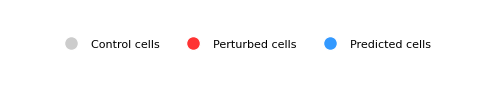

In [26]:
# Create a separate figure for the legend
legend_fig, legend_ax = plt.subplots(figsize=(5, 1))
handles = [
    plt.Line2D([0], [1], marker='o', color='w', markerfacecolor='#CCCCCC', markersize=10, label='Control cells'),
    plt.Line2D([0], [1], marker='o', color='w', markerfacecolor='#FF3333', markersize=10, label='Perturbed cells'),
    plt.Line2D([0], [1], marker='o', color='w', markerfacecolor='#3399FF', markersize=10, label='Predicted cells')
]
legend_ax.legend(handles=handles, loc='center', frameon=False, fontsize=8, labelcolor='black', ncol=3)
legend_ax.axis('off')  # Hide axes for the legend figure
plt.tight_layout()
legend_fig.savefig(f'{savedir}/legend.svg', format='svg')
plt.show()